# Reading the data

In [1]:
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

base_dir = "/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet"
df = pd.read_parquet(f'{base_dir}/partition_id=0/part-0.parquet')

df_pl = pl.read_parquet(f'{base_dir}/partition_id=0/part-0.parquet')

# Exploring the data

### Dataset Info

- **79 features and 9 responders**
  - *Anonymized but representing real market data. The training set contains historical data and returns.*

- **date_id** and **time_id**  
  - *Integer values that are ordinally sorted, providing a chronological structure to the data, although the actual time intervals between time_id values may vary.*

- **symbol_id**  
  - *Identifies a unique financial instrument.*

- **weight**  
  - *The weighting used for calculating the scoring function.*

- **feature_{00...78}**  
  - *Anonymized market data.*

- **responder_{0...8}**  
  - *Anonymized responders clipped between -5 and 5. The `responder_6` field is what we are trying to predict.*

### Goal
- Predict `responder_6`.
 responder_6 

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1944210 entries, 0 to 1944209
Data columns (total 92 columns):
 #   Column       Dtype  
---  ------       -----  
 0   date_id      int16  
 1   time_id      int16  
 2   symbol_id    int8   
 3   weight       float32
 4   feature_00   float32
 5   feature_01   float32
 6   feature_02   float32
 7   feature_03   float32
 8   feature_04   float32
 9   feature_05   float32
 10  feature_06   float32
 11  feature_07   float32
 12  feature_08   float32
 13  feature_09   int8   
 14  feature_10   int8   
 15  feature_11   int16  
 16  feature_12   float32
 17  feature_13   float32
 18  feature_14   float32
 19  feature_15   float32
 20  feature_16   float32
 21  feature_17   float32
 22  feature_18   float32
 23  feature_19   float32
 24  feature_20   float32
 25  feature_21   float32
 26  feature_22   float32
 27  feature_23   float32
 28  feature_24   float32
 29  feature_25   float32
 30  feature_26   float32
 31  feature_27   float32
 32

In [3]:
def print_empty_cols(df):
    empty_columns = []
    fully_filled_columns = []
    partially_empty_columns = []
    
    for feature in df.columns:
        # Count empty and non-empty rows
        empty_rows = df[feature].isnull().sum()
        nonempty_rows = len(df[feature]) - empty_rows
    

        # Classify the columns based on the counts
        if nonempty_rows == 0:
            empty_columns.append(feature)
        elif empty_rows == 0:
            fully_filled_columns.append(feature)
        else:
            partially_empty_columns.append(feature)
    
        # Print feature statistics
        print(f'{feature} : total - {len(df_pl[feature])} - empty - {empty_rows} - nonempty - {nonempty_rows}')

print_empty_cols(df)


date_id : total - 1944210 - empty - 0 - nonempty - 1944210
time_id : total - 1944210 - empty - 0 - nonempty - 1944210
symbol_id : total - 1944210 - empty - 0 - nonempty - 1944210
weight : total - 1944210 - empty - 0 - nonempty - 1944210
feature_00 : total - 1944210 - empty - 1944210 - nonempty - 0
feature_01 : total - 1944210 - empty - 1944210 - nonempty - 0
feature_02 : total - 1944210 - empty - 1944210 - nonempty - 0
feature_03 : total - 1944210 - empty - 1944210 - nonempty - 0
feature_04 : total - 1944210 - empty - 1944210 - nonempty - 0
feature_05 : total - 1944210 - empty - 0 - nonempty - 1944210
feature_06 : total - 1944210 - empty - 0 - nonempty - 1944210
feature_07 : total - 1944210 - empty - 0 - nonempty - 1944210
feature_08 : total - 1944210 - empty - 16980 - nonempty - 1927230
feature_09 : total - 1944210 - empty - 0 - nonempty - 1944210
feature_10 : total - 1944210 - empty - 0 - nonempty - 1944210
feature_11 : total - 1944210 - empty - 0 - nonempty - 1944210
feature_12 : to

In [4]:
# from IPython.display import display

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also

#     display(df.describe().drop(['date_id', 'time_id', 'symbol_id', 'weight'], axis = 1).T.style.background_gradient(cmap='coolwarm'))

In [5]:
df[df.date_id==0].symbol_id.unique()
df[df.date_id==1].symbol_id.unique()
df[df.symbol_id == 1].date_id.unique()

set(df[df.symbol_id == 1].date_id.unique()) - set(df[df.symbol_id == 7].date_id.unique())

{53, 71, 97}

In [6]:
mask1 = (df.symbol_id == 1) & (df.date_id == 0)

mask2 = (df.symbol_id == 7) & (df.date_id == 0)

list(set(df[mask1].time_id.unique()) - set(df[mask2].date_id.unique()))[:10]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Data Processing

In [7]:
df = df.drop(columns = ['responder_0','responder_1','responder_2','responder_3', 'responder_4', 'responder_5', 'responder_7', 'responder_8'])
df.head()

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6
0,0,0,1,3.889038,NaN,NaN,NaN,NaN,NaN,0.851033,...,-1.022690,0.152241,-0.659864,NaN,NaN,-0.261412,-0.211486,-0.335556,-0.281498,0.775981
1,0,0,7,1.370613,NaN,NaN,NaN,NaN,NaN,0.676961,...,-1.052685,-0.393726,-0.741603,NaN,NaN,-0.281207,-0.182894,-0.245565,-0.302441,0.703665
2,0,0,9,2.285698,NaN,NaN,NaN,NaN,NaN,1.056285,...,-0.863230,-0.241892,-0.709919,NaN,NaN,0.377131,0.300724,-0.106842,-0.096792,2.109352
3,0,0,10,0.690606,NaN,NaN,NaN,NaN,NaN,1.139366,...,-0.530602,4.765215,0.571554,NaN,NaN,-0.226891,-0.251412,-0.215522,-0.296244,1.114137
4,0,0,14,0.440570,NaN,NaN,NaN,NaN,NaN,0.955200,...,-1.141761,0.099631,-0.661928,NaN,NaN,3.678076,2.793581,2.618250,3.418133,-3.572820


## Percentage Based Column Filtering

In [8]:
# Sort the DataFrame
# The symbol_id refers to the individual stock. Since this data is chronological. 
# It must be sorted into groups: by stock then day, then time.

df = df.sort_values(by=['symbol_id', 'date_id', 'time_id'])
df = df.reset_index(drop=True)
df.head(100)

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6
0,1,0,0,1.749479,NaN,NaN,NaN,NaN,NaN,0.053447,...,-0.799783,4.812901,0.393107,NaN,NaN,-0.226359,-0.327119,-0.315040,-0.385573,2.337418
1,1,1,0,1.749479,NaN,NaN,NaN,NaN,NaN,-0.029047,...,-0.499520,3.384181,0.708746,NaN,NaN,-0.286174,-0.187674,-0.354506,-0.302946,2.492198
2,1,2,0,1.749479,NaN,NaN,NaN,NaN,NaN,0.017732,...,-0.697554,2.512118,0.715790,NaN,NaN,-0.324920,-0.306634,-0.342315,-0.330820,1.993902
3,1,3,0,1.749479,NaN,NaN,NaN,NaN,NaN,0.247528,...,-0.728824,2.111220,0.556564,NaN,NaN,-0.242646,-0.302316,-0.253091,-0.313789,1.864082
4,1,4,0,1.749479,NaN,NaN,NaN,NaN,NaN,-0.024495,...,-0.783194,1.114563,0.517224,NaN,NaN,-0.294731,-0.211305,-0.366540,-0.224103,2.604931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,95,0,1.749479,NaN,NaN,NaN,NaN,NaN,2.692226,...,2.311341,0.414055,1.270124,-0.253213,-0.333728,-0.275130,-0.223405,-0.176087,-0.164053,0.442783
96,1,96,0,1.749479,NaN,NaN,NaN,NaN,NaN,1.865496,...,1.573650,-0.034595,0.799987,-0.313146,-0.233692,0.960566,0.496793,-0.101656,-0.125825,0.702292
97,1,97,0,1.749479,NaN,NaN,NaN,NaN,NaN,1.897475,...,1.838099,-0.227945,0.682562,-0.138629,-0.188825,1.539052,2.265242,0.182376,0.162136,0.922618
98,1,98,0,1.749479,NaN,NaN,NaN,NaN,NaN,1.237614,...,2.424309,-0.286161,0.668957,-0.139529,-0.187903,1.672857,0.673290,0.216585,0.237390,0.914119


From the data exploration we saw that each feature column is not completely full. There are random points at which there are NANs or empty datapoints. <br>

Thus, need to be accounted for in some way. <br>

Our method is to process the data frame by stock (symbol_id). Each group contains all the time data (features) for a given stock. Our goal is to check the percentage of missing rows (NANs) for each group and individual feature. <br>

- If a feature for a stock is completely missing we drop the feature for the whole dataframe not just the group/stock.
- If the number of missing rows for a feature of a given stock exceeds a given percentage threshold, then the feature is also dropped for the whole dataframe. In this code the percentage threshold can be easily altered and is arbitrarily set to 10%.
- If there are any empty rows for the feature in that group then we forward and back fill those rows. Since the data is chronologically sorted in the previous step, ffill() and bfill() take the previous or forward time step data. They do not take random data from some other place in time. 
- If there are no empty rows nothing happens

The code uses lists: dropped columns, filled columns, and percent filled. These are used to track the changes to the dataframe and print out the changes made in the data preprocessing for each group. The processed_groups dataframe is used to store the changes of all the groups.

There is still an issue though with using ffill and bfill. If a symbol_id group starts with a significant portion of NaNs at the boundaries of the group (start and end), in feature_40 for example, ffill and bfill actually add more Nans. In these cases there are no valid non-NaN values to propagate using ffill or bfill. The percentage threshold, here set to 5%, allows feature_40 to remain despite having significant missing values in specific groups. Even after ffill and bfill residual NaNs remain due to boundary conditions, causing the incomplete filling.

In [9]:
# The % threshold of missing values for a given symbol_ID group at which to delete a feature from the whole df.
percentage_threshold = 5

# The processed_groups dataframe is used to store the changes for a given symbol ID.
processed_groups = pd.DataFrame(columns = ['Symbol ID', 'Dropped Columns', 'Filled Columns', '% Filled'])


# Iterates on the df into groups by symbol ID. These are already sorted by symbol, time, and date in the previous step
for symbol_id, group in df.groupby('symbol_id'):
    
    # lists to store the changes made to each group
    dropped_columns = []
    filled_columns = []
    percent_filled = []

    for feature in group.columns:
        # calculates percentage of missing rows for a feature in the group
        total_rows = len(group)
        empty_rows = group[feature].isnull().sum()
        empty_rows_percentage = (empty_rows / total_rows) * 100
        nonempty_rows_percentage = 100 - empty_rows_percentage
        
        # if the feature is empty or the % threshold of missing rows is exceeded --> delete the feature from the df
        if empty_rows == total_rows or empty_rows_percentage >= percentage_threshold:
            if feature in df.columns:
                df = df.drop(columns=feature)
                dropped_columns.append(feature)

        
        elif empty_rows > 0:      # Forward-fill and backward-fill missing values if lower than threshold and empty rows exist
            df.loc[group.index,feature] = group[feature].ffill().bfill()
            filled_columns.append(feature)
            percent_filled.append(empty_rows_percentage)

    # Check if there is data to add to the df for a given symbol_id group
    if dropped_columns or filled_columns or percent_filled:
        new_row = pd.DataFrame({
            'Symbol ID': [symbol_id],
            'Dropped Columns': [dropped_columns],
            'Filled Columns': [filled_columns],
            '% Filled': [percent_filled]
        })
    processed_groups = pd.concat([processed_groups, new_row], ignore_index=True)

remaining_null_columns = df.columns[df.isnull().any()]
print("Columns with remaining NaNs after ffill and bfill:", remaining_null_columns)
df = df.drop(columns=remaining_null_columns)


# print(processed_groups)

Columns with remaining NaNs after ffill and bfill: Index(['feature_40', 'feature_41', 'feature_43', 'feature_44', 'feature_63'], dtype='object')


In [10]:
# This is just a double check if there any missing rows left

null_columns = df.columns[df.isnull().any()]
print(null_columns)

Index([], dtype='object')


In [11]:
print_empty_cols(df)

date_id : total - 1944210 - empty - 0 - nonempty - 1944210
time_id : total - 1944210 - empty - 0 - nonempty - 1944210
symbol_id : total - 1944210 - empty - 0 - nonempty - 1944210
weight : total - 1944210 - empty - 0 - nonempty - 1944210
feature_05 : total - 1944210 - empty - 0 - nonempty - 1944210
feature_06 : total - 1944210 - empty - 0 - nonempty - 1944210
feature_07 : total - 1944210 - empty - 0 - nonempty - 1944210
feature_08 : total - 1944210 - empty - 0 - nonempty - 1944210
feature_09 : total - 1944210 - empty - 0 - nonempty - 1944210
feature_10 : total - 1944210 - empty - 0 - nonempty - 1944210
feature_11 : total - 1944210 - empty - 0 - nonempty - 1944210
feature_12 : total - 1944210 - empty - 0 - nonempty - 1944210
feature_13 : total - 1944210 - empty - 0 - nonempty - 1944210
feature_14 : total - 1944210 - empty - 0 - nonempty - 1944210
feature_15 : total - 1944210 - empty - 0 - nonempty - 1944210
feature_16 : total - 1944210 - empty - 0 - nonempty - 1944210
feature_17 : total 

Here we can see how there are no more NaNs in the df. 

## Principal Component Analysis - PCA

One way to get rid of features and to reduce the size of our large data set is through Principal Component Analysis. <br>

PCA transforms the feature set into a smaller and new set of uncorrelated variables called principal components (PCs). Our original feature set has 79 un-named features that we know nothing about. They could have linear relationships between them (they could be inter-correlated) that makes using all 79 features redundant and computationally expensive. It could also lead to overfitting. PCA helps to solve this by reducing the dimensionality of the data into a set of uncorrelated PCs. Each PC is essentially a distillation/reduction of the feature set. The PCs capture the most significant variations in the data as possible. These are new variables created by linear combinations of the original variables, where the first principal component (PC #1) explains the most variance in the data. The subsequent components progressively explain less and less variance (PC #2, PC #3, etc.). PCA inherently removes multicollinearity between the features by transforming the features into orthogonal PCs.

How the algorithm works:
* calculate the covariance matrix of the data to determines the relationships between variables. 
* The covariance matrix is then decomposed into eigenvalues and eigenvector. The eigenvectors represent the directions of maximum variance and the eigenvalues represent the amount of variance explained by each component
* A subset of principal components with the highest variance are chosen to represent the feature set. These are specified when running the model.

However the data must be normalized first before running principle component analysis.
* PCA works by identifying the directions (principal components) that maximize the variance in the data. If the features have different scales (e.g., one feature ranges from 0 to 1, while another ranges from 0 to 1000), the variance of the features with larger ranges will dominate. This would cause PCA to incorrectly weight those features in its calculations.


Thus we must use Standard Scaler before before implementingre PCA. <br>

Standard Scaler ensures:
* All features are centered around 0 with unit variance (mean = 0, variance = 1).
* The variance of each feature contributes equally when PCA calculates the covariance matrix of the feature set

However standard scaler must be performed on the individual symbol_id groups (the full set of date and time id's for a given symbol id). Normalizing each group independently is necessary as each symbol id represents distinct entities (individual stocks) with no shared scale or distribution. At least we have no way on knowing since the data is unlabeled. Thus to be safe, we decided to apply standard scaler on individual symbol_id groups. Furthermore, by applying standard scalar, PCA will now identify meaningful principal components rather than being skewed by unscaled feature magnitudes. 

For the PCA calculations however, this must be applied globally. Using the sklearn PCA model, we chose the model give us the the top 'n' PCs that represent a 90% of the variance of the feature set. It this threshold was applied to each symbol id_group, we might get three PC columns needed to reach the threshold for the 1st symbol_id and then 5 needed for the 2nd symbol_id group. This means that the df of the final feature set could not merge the symbol_id PC columns (different dimensions). Additionally, if we were to use the largest number of PC columns needed to reach the threshold (e.g. 6 PC columns due to symbol_id 2) and share this with the rest of the symbol_id groups, this would cause, for example, symbol_id to explain more than 90% of the variance. Thus we decided to apply PCA globally on the feature set.


### Normalizing the data


* We must normalize only on the remaining features. Not on time,data,symbol,etc. 

In [12]:
# Normalize just the features

from sklearn.preprocessing import StandardScaler

df_feature_cols = []

# All the possible feature columns in the original data file
possible_feature_cols = [f'feature_{i:02}' for i in range(0,79)]

# Check which features are remaining after the preprocessing
for feature in df.columns:
    if feature in possible_feature_cols:
        df_feature_cols.append(feature)


# Standardize the individual groups and only on the remaining features
for symbol_id, group in df.groupby('symbol_id'):
    std_scaler = StandardScaler()
    df.loc[group.index, df_feature_cols] = std_scaler.fit_transform(group[df_feature_cols])

* Lets make sure that the standard scaler is applied correctly. Standard scaler ensures that each feature has a mean of 0 and a standard deviation of 1. 

* If the standard deviation if 1, the variance becomes:  Variance=(Standard Deviation)^2 = 1^2 =1
* This is why most if all features now have a variance of 1.

In [13]:
variances = df.drop(['date_id', 'time_id', 'symbol_id', 'weight'], axis=1).var()
summary = df.describe().drop(['date_id', 'time_id', 'symbol_id', 'weight'], axis=1).T
summary['variance'] = variances

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(summary.style.background_gradient(cmap='coolwarm'))


,count,mean,std,min,25%,50%,75%,max,variance
feature_05,1944210.000000,-0.000000,1.000000,-13.166103,-0.468021,-0.014746,0.426808,15.371867,1.000000
feature_06,1944210.000000,0.000000,1.000000,-23.328115,-0.366534,-0.006040,0.339358,24.230495,1.000000
feature_07,1944210.000000,-0.000000,1.000000,-18.487604,-0.420731,-0.014323,0.382832,25.195225,1.000000
feature_08,1944210.000000,-0.000000,1.000000,-7.610195,-0.535809,-0.034787,0.469149,15.806594,1.000000
feature_09,1944210.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
feature_10,1944210.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
feature_11,1944210.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
feature_12,1944210.000000,-0.000000,1.000000,-2.351544,-0.533084,-0.232653,0.222173,23.696554,1.000000
feature_13,1944210.000000,-0.000000,1.000000,-1.172081,-0.403503,-0.260976,-0.003155,63.608902,1.000000
feature_14,1944210.000000,-0.000000,1.000000,-2.019938,-0.495114,-0.259361,0.158226,35.363472,1.000000


* We can also see that features 9, 10, and 11 do not have a variance of 1. This is because their min and max values are all very close to the mean of 0. Thus there is no variance in the data.
* Thus these features are not significant in predicting responder 6 if they do not change at all with time.

### Running PCA

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Threshold of number of PC Columns that explain 90% of the data
threshold = 0.9

pca = PCA()
pca.fit(df[df_feature_cols])

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)


# +1 since it is 0-indexed. So result can give actual number of components
threshold_components = np.argmax(cumulative_variance >= threshold) + 1

pca_optimal = PCA(n_components = threshold_components)
pca_data_cols = pca_optimal.fit_transform(df[df_feature_cols])

for i in range(1,threshold_components + 1):
    df[f'PCA_{i}'] = pca_data_cols[:,i-1]

df = df.drop(columns = df_feature_cols)

df.head()

,date_id,time_id,symbol_id,weight,responder_6,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,...,PCA_20,PCA_21,PCA_22,PCA_23,PCA_24,PCA_25,PCA_26,PCA_27,PCA_28,PCA_29
0,1,0,0,1.749479,2.337418,-1.659450,3.545029,-2.142800,4.254930,1.005202,...,-1.177688,1.848448,-0.286035,-1.806068,0.115206,-0.983027,-1.135854,0.323517,0.595715,-0.999871
1,1,1,0,1.749479,2.492198,0.726793,3.062720,-1.059598,2.384442,-1.793435,...,-0.670492,0.373491,0.285066,-1.855919,0.219238,-1.128989,-0.646388,0.051471,0.195445,-0.192429
2,1,2,0,1.749479,1.993902,0.637628,2.558551,-1.076644,2.479048,-1.495939,...,-1.105623,0.307387,0.433994,-1.743260,0.114351,-0.958608,-1.006748,-0.024975,0.110547,-0.162304
3,1,3,0,1.749479,1.864082,0.062910,1.868462,-0.807759,2.519888,-1.250419,...,-0.677235,0.687599,-0.190933,-1.517280,-0.673986,-0.644045,-0.388010,-0.002154,0.417270,-0.111708
4,1,4,0,1.749479,2.604931,-0.405875,1.063381,-0.499986,2.390526,-1.914529,...,-0.643016,0.247866,0.021429,-0.807200,-1.173701,-0.146500,0.091285,0.182532,0.365158,-0.138530


Thus, 29 PCs are necessary to reach the 90% variance threshold for this feature set.

In [15]:

# # Number of principal components to initially calculate from a symbol_id's feature set
# n = 3

# for symbol_id, group in df.groupby('symbol_id'):
#     pca = PCA(n_components = n)
#     pca_data_cols = pca.fit_transform(group[df_feature_cols])
#     df.loc[group.index, [f'PCA_{i}' for i in range(1,n+1)]] = pca_data_cols
    
# df = df.drop(columns = df_feature_cols)

# df.head()

## One Hot Encoding

In our data set the numeric representation of Symbol_id (e.g. '1' or '2') doesn't imply order:
* Symbol_id is a categorical variable. Thus the numeric value of symbol_id does not have a meaningful order (e.g., 1, 2, 3 aren't inherently "larger" or "smaller").

One Hot Encoding avoids misinterpretation by the models we will use:
* Using raw numeric values could mislead the model into interpreting the column as continuous (e.g., implying a distance between symbol_id = 1 and symbol_id = 2). One-Hot Encoding converts categorical variables into binary indicators that can be safely used in our machine learning models.

In [16]:
encoded = pd.get_dummies(df['symbol_id'], prefix='symbol_id')
max_symbol_id = df['symbol_id'].max()
print(f'This parquet has {max_symbol_id} distinct symbol_ids')
encoded.head()

This parquet has 38 distinct symbol_ids


,symbol_id_0,symbol_id_1,symbol_id_2,symbol_id_3,symbol_id_7,symbol_id_8,symbol_id_9,symbol_id_10,symbol_id_11,symbol_id_12,symbol_id_13,symbol_id_14,symbol_id_15,symbol_id_16,symbol_id_17,symbol_id_19,symbol_id_30,symbol_id_33,symbol_id_34,symbol_id_38
0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [17]:
df = pd.concat([df, encoded], axis = 1)
df = df.drop(['symbol_id'], axis = 1)
df.head()

,date_id,time_id,weight,responder_6,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,...,symbol_id_13,symbol_id_14,symbol_id_15,symbol_id_16,symbol_id_17,symbol_id_19,symbol_id_30,symbol_id_33,symbol_id_34,symbol_id_38
0,1,0,1.749479,2.337418,-1.659450,3.545029,-2.142800,4.254930,1.005202,-3.453652,...,False,False,False,False,False,False,False,False,False,False
1,1,1,1.749479,2.492198,0.726793,3.062720,-1.059598,2.384442,-1.793435,-1.979569,...,False,False,False,False,False,False,False,False,False,False
2,1,2,1.749479,1.993902,0.637628,2.558551,-1.076644,2.479048,-1.495939,-1.656335,...,False,False,False,False,False,False,False,False,False,False
3,1,3,1.749479,1.864082,0.062910,1.868462,-0.807759,2.519888,-1.250419,-1.904519,...,False,False,False,False,False,False,False,False,False,False
4,1,4,1.749479,2.604931,-0.405875,1.063381,-0.499986,2.390526,-1.914529,-1.423650,...,False,False,False,False,False,False,False,False,False,False


## Temporal Splitting

In [18]:
df = df.sort_values(['date_id', 'time_id'])
date_counts = df.date_id.value_counts()

In [19]:
date_counts = pd.DataFrame(date_counts.sort_index())
date_counts['cumulative_sum'] = date_counts['count'].cumsum()
date_counts.head()

,count,cumulative_sum
date_id,,
0,6792,6792
1,10188,16980
2,9339,26319
3,10188,36507
4,10188,46695


In [20]:
total = len(df)
train_percentage = 0.6
val_percentage = 0.2
test_percentage = 0.2

apprx_train_len = int(total*train_percentage)
apprx_val_len = int(total*val_percentage)
apprx_test_len = total - apprx_train_len - apprx_val_len



def split_func(row):
    s = row['cumulative_sum']
    
    if s <= apprx_train_len:
        return 'Train'

    elif (s > apprx_train_len) and (s <= apprx_train_len + apprx_val_len):
        return 'Val'

    elif (s > apprx_train_len + apprx_val_len):
        return 'Test'

    else:
        raise ValueError



date_counts['Split'] = date_counts.apply(split_func, axis = 1)
print(date_counts.Split.value_counts())
date_counts.head()

Split
Train    113
Val       30
Test      27
Name: count, dtype: int64


,count,cumulative_sum,Split
date_id,,,
0,6792,6792,Train
1,10188,16980,Train
2,9339,26319,Train
3,10188,36507,Train
4,10188,46695,Train


In [21]:
last_train_data = date_counts[date_counts.Split == 'Train'].tail(1)

first_test_data = date_counts[date_counts.Split == 'Test'].head(1)


In [22]:
last_train_index = last_train_data.index[0]
first_test_index = first_test_data.index[0]


df['Split'] = 'Test'
df.loc[df['date_id'] <= last_train_index, 'Split'] = 'Train'
df.loc[(df['date_id'] > last_train_index) & (df['date_id'] < first_test_index), 'Split'] = 'Val'

print(df['Split'].value_counts())

Split
Train    1158036
Test      398181
Val       387993
Name: count, dtype: int64


In [23]:
train_df = df[df.Split == 'Train']
val_df = df[df.Split == 'Val']
test_df = df[df.Split == 'Test']

## Setting the features

Our final features are:
* Date_id
* Time_id
* PCA columns 1 -> n
* Boolean Symbol_id columns

In [24]:
TEMPORAL_FEATURES = ['date_id', 'time_id']

MARKET_FEATURES = [f'PCA_{i}' for i in range(1,i+1)]

SYMBOL_FEATURES = [f'symbol_id_{i}' for i in range(max_symbol_id) if f'symbol_id_{i}' in df.columns]

In [25]:
ALL_FEATURES = TEMPORAL_FEATURES + MARKET_FEATURES + SYMBOL_FEATURES

In [26]:
train_x = train_df[ALL_FEATURES]
train_y = train_df[['responder_6']]

val_x = val_df[ALL_FEATURES]
val_y = val_df[['responder_6']]

test_x = test_df[ALL_FEATURES]
test_y = test_df[['responder_6']]

# Regression Models

In [27]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet


## Ridge Regression

Penalty: Squares the magnitude of the coefficients in loss function <br>


Cost Function:J(β) = RSS + α ∑βᵢ^2

Where:

- RSS is the Residual Sum of Squares (error term).
- βₖ are the model's coefficients.
- α controls the strength of the penalty. Larger α forces coefficients closer to zero.

Behavior:
- Penalizes large coefficients by squaring them.
- Reduces multicollinearity (correlation between predictors).
- Keeps all features but shrinks their coefficients towards zero.
- Best for situations where many predictors are useful.

Thus we would want to use ridge regression when feature reduction is not possible and multicollinearity is present. However, we have PCA features which are linearly uncorrelated by design. PCA inherently removes multicollinearity by transforming the features into orthogonal principal components. Fortunately, ridge regression can still be beneficial when using PCA features with high-dimensionality that could cause overfitting.

Ridge regression introduces a penalty that shrinks the coefficients of less important components, helping to stabilize the model and improve generalization to unseen data. This combination ensures that the PCA captures the most variance while ridge regression handles potential overfitting and ensures robust predictions. 

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.65167e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.65168e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.65168e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.65169e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarnin

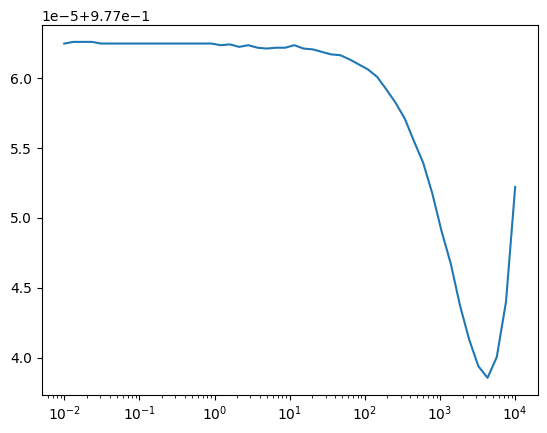

Minimum MSE = 0.977038562297821 at alpha = 4291.934260128778


In [28]:
ridge_mse = []

# Ridge Regression
# Typical values of alpha are 0.01 to 10,000
# 20 alpha values from 0.01 to 10000 in logarithmic scaling
alpha_counter = np.logspace(-2, 4, 50)


for a in alpha_counter:
    ridge = Ridge(alpha=a, random_state=42)
    ridge.fit(train_x, train_y)
    ridge_y_pred = ridge.predict(test_x)
    ridge_mse.append(mean_squared_error(test_y, ridge_y_pred))
    del ridge



plt.plot(alpha_counter,ridge_mse)
plt.xscale('log')
plt.show()



# argmin() finds index of minimnum value
min_mse_index = np.argmin(ridge_mse)
print(f'Minimum MSE = {ridge_mse[min_mse_index]} at alpha = {alpha_counter[min_mse_index]}')
ra = alpha_counter[min_mse_index]

### Lasso Regression



Penalty: Takes the absolute value of the coefficients in loss function <br>


Cost Function:J(β) = RSS + α ∑ |βᵢ|

Behavior:
- Penalizes large coefficients by their absolute values.
- Performs feature selection: can set some coefficients to exactly 0, effectively removing irrelevant features.
- Best for situations where only a subset of predictors is relevant

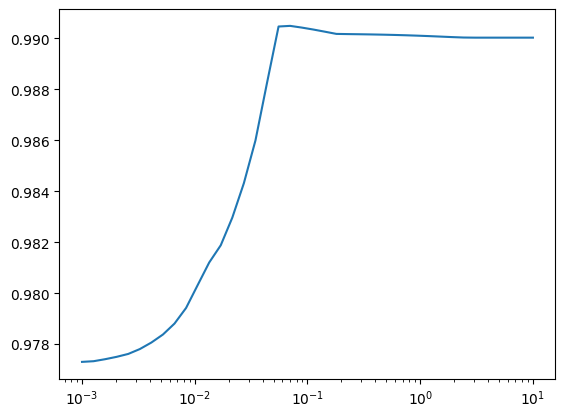

Minimum MSE = 0.9773000478744507 at alpha = 0.001


In [29]:
lasso_mse = []
Lalpha_counter = np.logspace(-3, 1, 40)


for a in Lalpha_counter:
    lasso = Lasso(alpha=a, random_state=42)
    lasso.fit(train_x, train_y)
    lasso_y_pred = lasso.predict(test_x)
    lasso_mse.append(mean_squared_error(test_y, lasso_y_pred))
    del lasso


plt.plot(Lalpha_counter,lasso_mse)
plt.xscale('log')
plt.show()



# argmin() finds index of minimnum value
min_mse_index = np.argmin(lasso_mse)
print(f'Minimum MSE = {lasso_mse[min_mse_index]} at alpha = {Lalpha_counter[min_mse_index]}')
la = Lalpha_counter[min_mse_index]

### Checking Elastic Results

Elastic Regression combines both Ridge and Lasso Regression


Cost Function:J(β) = RSS + α1 ∑βᵢ^2 + α2 ∑ |βᵢ|

Behavior:
- Hybrid approach: Balances feature selection (Lasso) and coefficient shrinkage (Ridge).
- Useful when there are multiple correlated features, and Lasso struggles to choose one.


In [30]:
l1_alpha_values = np.logspace(-3, 2, 10)  # 10 values from 0.001 to 100
l1_ratios = np.linspace(0.1, 1.0, 10)  # 10 values from 0.1 to 1.0


elastic_mse_results = np.zeros((len(l1_alpha_values), len(l1_ratios)))


for i, a in enumerate(l1_alpha_values):
    for j, l1 in enumerate(l1_ratios):
        elastic_net = ElasticNet(alpha=a, l1_ratio=l1, random_state=42)
        elastic_net.fit(train_x, train_y)
        elastic_net_y_pred = elastic_net.predict(test_x)
        elastic_mse_results[i, j] = mean_squared_error(test_y, elastic_net_y_pred)


min_mse_index = np.unravel_index(np.argmin(elastic_mse_results, axis=None), elastic_mse_results.shape)
optimal_alpha = l1_alpha_values[min_mse_index[0]]
optimal_l1_ratio = l1_ratios[min_mse_index[1]]



print(f"Optimal Alpha: {optimal_alpha}")
print(f"Optimal L1 Ratio: {optimal_l1_ratio}")
print(f"Minimum MSE: {elastic_mse_results[min_mse_index]}")

Optimal Alpha: 0.001
Optimal L1 Ratio: 0.1
Minimum MSE: 0.9770663380622864


### Decision Trees and XGBoost

In [31]:
# Import libraries

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score



# Models for regression
regressors = {
    "Ridge Regression" : Ridge(alpha= ra, random_state=42),
    "Lasso Regression" : Lasso(alpha = la, random_state=42),
    "Elastic Regression" : ElasticNet(alpha=optimal_alpha, l1_ratio=optimal_l1_ratio, random_state=42),
    "Decision Tree": DecisionTreeRegressor(max_depth=5, random_state=42),
    "Linear Regression": LinearRegression(),
    "XGBoost": xgb.XGBRegressor(tree_method="hist")
}



# Performance metrics for regression
metrics = {
    "Mean Squared Error": mean_squared_error,
    "Mean Absolute Error": mean_absolute_error,
    "R^2 Score": r2_score,
}

In [32]:
import time

results_train = {}
results_val = {}

models = list(regressors.keys())
elap_time = []


mse_train = []
mse_test = []
mse_val = []

mae_train = []
mae_test = []
mae_val = []

r2_train = []
r2_test = []
r2_val = []



for model in regressors:
    start_time = time.time()
    
    regressors[model].fit(train_x, train_y)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    elap_time.append(elapsed_time)
    
    pred_y_train = regressors[model].predict(train_x)
    pred_y_test = regressors[model].predict(test_x)    
    pred_y_val = regressors[model].predict(val_x)
    
    train_list = []
    val_list = []
    for metric in metrics:
        score_train = metrics[metric](train_y, pred_y_train)
        score_train = round(score_train, 4)
        
        score_test = metrics[metric](test_y, pred_y_test)
        score_test = round(score_test, 4)     
        
        score_val = metrics[metric](val_y, pred_y_val)
        score_val = round(score_val, 4)
        
        if metric == "Mean Squared Error":
            mse_train.append(score_train)
            mse_test.append(score_test)
            mse_val.append(score_val)
            
        elif metric == "Mean Absolute Error":
            mae_train.append(score_train)
            mae_val.append(score_val)
            mae_test.append(score_test)

        elif metric == "R^2 Score":
            r2_train.append(score_train)
            r2_val.append(score_val)
            r2_test.append(score_test)
            
                   

regression_results = pd.DataFrame({
    'Model': models,
    'Elapsed Time': elap_time,
    'MSE Train': mse_train,
    'MSE Test': mse_test,
    'MSE Val': mse_val,
    'MAE Train': mae_train,
    'MAE Test': mae_test,
    'MAE Val': mae_val,
    'R² Train': r2_train,
    'R² Test': r2_test,
    'R² Val': r2_val
})

regression_results

,Model,Elapsed Time,MSE Train,MSE Test,MSE Val,MAE Train,MAE Test,MAE Val,R² Train,R² Test,R² Val
0,Ridge Regression,0.743282,0.6595,0.9770,0.7785,0.5187,0.6576,0.5721,0.0135,0.0130,0.0100
1,Lasso Regression,4.615115,0.6598,0.9773,0.7781,0.5185,0.6575,0.5719,0.0131,0.0127,0.0105
2,Elastic Regression,5.952714,0.6595,0.9771,0.7785,0.5187,0.6576,0.5722,0.0135,0.0130,0.0100
3,Decision Tree,38.807482,0.6622,0.9836,0.7841,0.5199,0.6601,0.5738,0.0095,0.0063,0.0029
4,Linear Regression,3.682328,0.6595,0.9771,0.7786,0.5187,0.6576,0.5722,0.0135,0.0130,0.0098
5,XGBoost,20.385838,0.5575,1.0397,0.8225,0.4916,0.6836,0.5949,0.1661,-0.0504,-0.0460


### Results

1. Ridge, Lasso, Elastic
   * The MSE values for the MSE train are all nearly identical for these three models. This pattern occurs again with the test and validation data. The Train MSE is the lowest at around 0.659 while the MSE test data is the highest at 0.977. This indicates that the model is slightly overfitting. However, we have no way of knowing how large of a difference this is, as we do not have the units of our target variable Responder_6. All we know is lower is better. Knowing the units helps in understanding how significant the errors are in real-world terms.
   * MAE shows the same pattern: the train, test, and validation columns are the same. However, this time the MAE train and test are closer together as compared to the MSE (MAE test of 0.51 and MAE train of 0.65). Furthermore, similar MAE test and MAE val results (0.65 for test and 0.57 for val) demonstrate consistent generalization performance
   * Again, R2 shows repetitive performance across the three models. Since the results are similar, at around 0.01, this means that the model only explains a small portion of the variance in Responder_6. R2 measures how well the model explains the variance in the target variable. It ranges from -infinity to 1, where 1 means that the model explains all the variance in the target and 0 means the model explains none of the variance. Less than 0 means the model is worse than guessing. Although the R2 is similar for train, test, and val it does slightly decrease in test and val. This could mean that the dataset is not suitable for these linear regression models. It suggests that the dataframe is either inherently noisy or lacks strong linear relationships between the features and responder_6.
2. Decision Tree
   * This model had slightly worse performance than the ridge, lasso, and elastic models. The MSE train, test, and val results where almost exactly the same but slightly higher (0.66 compared with 0.65, 0.98 compared with 0.97, and 0.78 compared with 0.77). Again, the trend between the train and test suggests the model is overfitting. This trend is also present for MAE.
   * The R2 values are all significantly lower than the previous models. Even R2 val is 0.0032. This means that the model essentially does not explain any of the variance in responder_6. In addition, to the poor results, the model also took over 38 seconds to compile. Thus this model is not worth to use.
3. Linear Regression
   * The results are pretty much exactly the same as those for ridge regression surprisingly. However, Ridge regression does take less to compile and has slighly slower values (by 0.001 for example). Thus, ridge regression slightly edges out linear regression.
4. XGBoost
   * This model is the by far the model which overfits the most. The the MSE train is the lowest at 0.55 but then has a MSE test of 1.05 which is the highest.
   * The MAE however is similar to the previous models.
   * The R2 values for the test and val data are all below 0. This means that Xboost is worse than using the mean of responder_6 as a constant prediction for every input. This is again a sign that the relationship between features and responder_6 might be non-linear.
  
5. Overall
   * Due to the poor r2 results for all the models, it can be conlcluded that these regression models are not perfectly suitable for this dataset.
   * It is important to note that polynomial regression was attempted on the dataset but was too computationally expensive for kaggle to run (even for a 2nd order polynomial). We suspect however that the data does not have a linear relationship and must be model using higher order polynomials or other types of models.
   * **However, the units of MSE are the square of the target's (responder_6) units. So a val mse of 0.77 (in the best case) equates to a RMSE of 0.877. This means that on average these regression models deviate by about 0.877 responder_6 units. In the data-preprocessing section we can see that the range of responder_6 is -5 to 5 with the mean at 0. Thus, this represents 8.77% of responder_6's range. However since we, again, don't know what responder 6 is, we don't know if this is good or bad. Here, "good performance" depends on the context of the problem. For financial modeling 8.66% could be a very large innaccuracy.**

#### Neural Nets

In [33]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [34]:
input_shape=train_x.shape[1:]
print(input_shape)

(50,)


From the regression results the main goal is to prevent overfitting our data between the train and test sets.

L2 Regularization:
* We added kernel_regularizer=tf.keras.regularizers.l2(0.001) to dense layers to penalize large weights and reduce overfitting.
* It prevents the model from assigning excessively large weights to certain features. Thus it should prevent overfitting by reducing the model's reliance on any single feature. This shold create a simpler model that s better on unseen data (the validation set).
* This should help model performance on validation set.
  
Dropout:
* Dropout is a regularization technique that chooses a random subset of neurons and temporarily "drops" it (set to zero) during each training batch. This prevents co-dependency among neurons, which forces the network of nuerons to learn its own reduntant/overfitting behavior. 
* We added tf.keras.layers.Dropout(0.3) after each activation layer to randomly disable 30% of neurons during training.
* This also helps prevent overfitting.



Reduced Learning Rate:
* We set the learning_rate = 0.001 in the Adam optimizer for smaller weight updates during training.
* A lower learning rate takes longer but reduces the risk of the model overshooting the optimal neuron weights.
   
Early Stopping:
* We added EarlyStopping to halt training if validation loss does not improve for 5 consecutive epochs. Here the loss function is the validation set MSE. By added EarlingStopping this should prevent overfitting and also make a faster runnning model.

In [35]:
model = tf.keras.Sequential([

    tf.keras.layers.Flatten(input_shape=input_shape),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal",kernel_regularizer=tf.keras.regularizers.l2(0.001), use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
     # add a drop out layer to prevent overfitting 
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(100, kernel_initializer="he_normal",kernel_regularizer=tf.keras.regularizers.l2(0.001), use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),

   
    tf.keras.layers.Dropout(0.3),

    # Single output neuron for regression. We want to predict just Responder_6
    tf.keras.layers.Dense(1, activation=None)

])



# tf.keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [37]:
# Early stopping callback --> stops model from running more epochs without improvement
# It monitors validation loss and stops training after 5 epochs of no improvement
# Restores model weights from the best epoch
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=5,          
    restore_best_weights=True  
)



model.compile(loss="mse",
              # reduced learning rate
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=["mse", "mae"])

history = model.fit(train_x.values.astype('float32'), 
                    train_y.values.astype('float32'),
                    batch_size = 1024,
                    validation_data = (val_x.values.astype('float32'), val_y.values.astype('float32')),
                    epochs=30,
                    callbacks=[early_stopping]
                   )

Epoch 1/30
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - loss: 0.6633 - mae: 0.5198 - mse: 0.6618 - val_loss: 0.7860 - val_mae: 0.5762 - val_mse: 0.7845
Epoch 2/30
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 0.6630 - mae: 0.5195 - mse: 0.6616 - val_loss: 0.7796 - val_mae: 0.5716 - val_mse: 0.7783
Epoch 3/30
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.6628 - mae: 0.5196 - mse: 0.6615 - val_loss: 0.7825 - val_mae: 0.5733 - val_mse: 0.7811
Epoch 4/30
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 0.6628 - mae: 0.5195 - mse: 0.6614 - val_loss: 0.7794 - val_mae: 0.5713 - val_mse: 0.7780
Epoch 5/30
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 0.6627 - mae: 0.5194 - mse: 0.6613 - val_loss: 0.7828 - val_mae: 0.5723 - val_mse: 0.7814
Epoch 6/30
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 0.6627 - mae: 0.5196 - mse: 0.6613 - val_loss: 0.7896 - val_mae: 0.5793 - val_mse: 0.7883
Epoch 7/30
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 0.6630 - mae

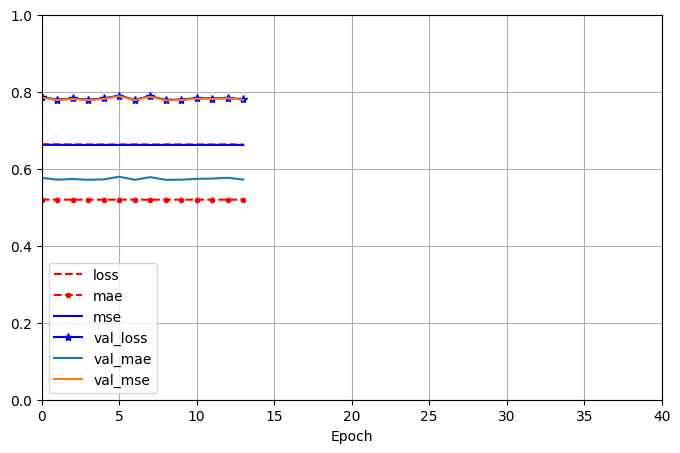

In [39]:
pd.DataFrame(history.history).plot(

    figsize=(8, 5), xlim=[0, 40], ylim=[0, 1], grid=True, xlabel="Epoch",

    style=["r--", "r--.", "b-", "b-*"])

plt.legend(loc="lower left")  # extra code

plt.show()

### Results
1. We can see that the EarlyStopping function stopped the model training after 14 epochs.
2. Training Metrics:
    * Loss: 0.6626 (equal to MSE since the loss function is set to "mse")
    * MAE: 0.5194
    * MSE: 0.6613
    * The Loss and MSE are the very similar since the loss function is, again, set to "mse"
    * The Mean Absolute Error is 0.5194, which represents the average absolute difference between the predicted and actual values in the training set. Since the target range is this error corresponds to 5.19% of the range on average.
3. Validation Metrics:
    * val_loss: 0.7804
    * val_mae: 0.5718
    * val_mse: 0.7790
4. Overall
    * Since the validation loss is higher than the training loss, this means that model performs slightly worse on the unseen validation set. Again however, we don't know if this signifies a lot of overfitting or slight overfitting. We don't know the units or context of responder_6.
    * The best results of the normal regression models was a train MSE of 0.65 and a validation MSE of 0.77. The results of the neural net was a train MSE of 0.66 and a val MSE of 0.77. This is essentially the same output as the normal regression models.
    * For MAE, the best results of the normal regression models was a train MAE of 0.49 and a validation MAE of 0.59. For the neural net it was 0.51 and 0.57 respectively. This is a smaller gap and smaller MAE validation value too. Thus the neural net performed better than the regression models for MAE.
    * Since the results are almost the same as the normal regressino models, we would recommend to just use elastic, ridge, or lasso regression. If the results are the same, normal regression models don't have the same computational expense as nueral nets do. Plus they are faster too!

In [73]:
test_x = test_df[ALL_FEATURES]

test_y = test_df[['responder_6']]

In [74]:
pred_y_test = model.predict(test_x.values.astype('float32'), batch_size = 1024)

389/389 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [ ]:
# Performance
results_test = {}

for model in regressors:
  print(f"Model: {model}")
  if 'Neural Net' in model:
      pred_y_test = regressors[model].predict(test_x.values.astype('float32'), batch_size = 1024)
  else:
      pred_y_test = regressors[model].predict(test_x)

  results = []

  for metric in metrics:
    score = metrics[metric](test_y, pred_y_test)
    print(f"{metric}: {round(score,4)}")
    results.append(score)
      
  results_test[model] = results

  print()

### Feature Importance

In [ ]:
from xgboost import plot_importance
plt.figure(figsize = (10,20))

plot_importance(regressors["XGBoost"])
plt.savefig('feature_importance.png', dpi = 300)